In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycwt as wavelet
from scipy import signal
import yfinance as yf

import warnings

warnings.filterwarnings('ignore')

# data preprocessing 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(740, 1)
(740, 1)


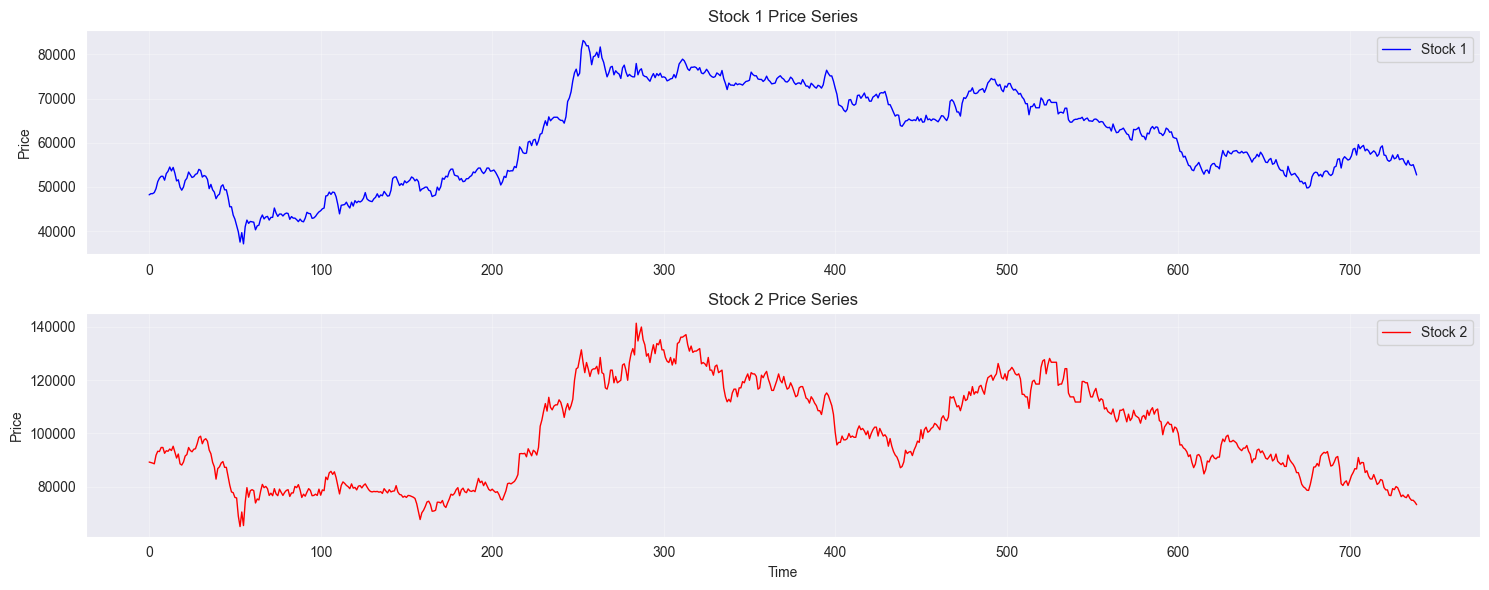

In [195]:
# 두 주식의 데이터 다운로드
stock1_data = yf.download('005930.KS', start='2020-01-01', end='2023-01-01')  # 삼성전자
stock2_data = yf.download('000660.KS', start='2020-01-01', end='2023-01-01')  # SK하이닉스

# 종가 데이터 추출
stock1_close = stock1_data['Close'].values
stock2_close = stock2_data['Close'].values
time_real = np.arange(len(stock1_close))
time_len=len(stock1_close)

# 로그 수익률 계산
stock1_returns = np.log(stock1_close[1:] / stock1_close[:-1])
stock2_returns = np.log(stock2_close[1:] / stock2_close[:-1])

print(stock1_close.shape)
print(stock2_close.shape)

# 데이터 시각화
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time_real, stock1_close, 'b-', label='Stock 1', linewidth=1)
plt.title('Stock 1 Price Series')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_real, stock2_close, 'r-', label='Stock 2', linewidth=1)
plt.title('Stock 2 Price Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# individual_wavelet_spectrum

In [196]:
import numpy as np
import pandas as pd
import pycwt as wavelet

def calculate_individual_wavelet_spectrum(signal, dt=1.0, dj=1/12, s0=None, J=None, 
                                               wavelet_type='morlet'):
    """
    개별 신호의 웨이브렛 스펙트럼 계산
    """
    
    # 입력 데이터 검증 및 전처리
    signal = np.array(signal).flatten()  # 1차원 배열로 변환
    
    if len(signal) < 4:
        raise ValueError("신호 길이가 너무 짧습니다. 최소 4개 이상의 데이터 포인트가 필요합니다.")
    
    # NaN 값 처리
    if np.any(np.isnan(signal)):
        print("경고: 신호에 NaN 값이 포함되어 있습니다. 선형 보간으로 처리합니다.")
        signal = pd.Series(signal).interpolate().values
    
    # 신호 길이를 2의 거듭제곱에 가깝게 조정 (선택사항)
    N = len(signal)
    
    # 웨이브렛 선택
    if wavelet_type.lower() == 'morlet':
        mother = wavelet.Morlet(6)
    elif wavelet_type.lower() == 'paul':
        mother = wavelet.Paul(4)
    elif wavelet_type.lower() == 'dog':
        mother = wavelet.DOG(2)
    else:
        mother = wavelet.Morlet(6)
    
    # 보수적인 파라미터 설정
    if s0 is None:
        s0 = 2 * dt
    
    # J 값을 더 보수적으로 계산
    if J is None:
        # 데이터 길이에 기반한 안전한 J 계산
        max_scale = N * dt / 4  # 최대 스케일을 데이터 길이의 1/4로 제한
        J = int(np.log2(max_scale / s0) / dj)
        J = min(J, 60)  # 최대 60개 스케일로 제한
    
    # 최소 J 값 보장
    J = max(J, 10)
    
    try:
        # 연속 웨이브렛 변환 수행
        W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
        )
        
        # 파워 스펙트럼 계산
        power = (np.abs(W)) ** 2
        period = 1 / freqs
        
        print(f"웨이브렛 변환 성공: {len(signal)}개 데이터 포인트, {len(freqs)}개 주파수 대역")
        
    except Exception as e:
        print(f"웨이브렛 변환 중 오류 발생: {e}")
        print("더 보수적인 파라미터로 재시도...")
        
        # 더욱 보수적인 파라미터로 재시도
        J = min(20, J // 3)  # J를 1/3로 줄임
        s0 = 4 * dt
        dj = 1/6  # 해상도를 낮춤
        
        try:
            W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
                signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
            )
            power = (np.abs(W)) ** 2
            period = 1 / freqs
            
            print(f"보수적 파라미터로 재계산 완료: J={J}, s0={s0}, dj={dj}")
            
        except Exception as e2:
            print(f"재시도도 실패: {e2}")
            # 최후의 수단: 매우 보수적인 설정
            J = 10
            s0 = 8 * dt
            dj = 1/4
            
            W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
                signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
            )
            power = (np.abs(W)) ** 2
            period = 1 / freqs
            
            print(f"최소 설정으로 계산 완료: J={J}, s0={s0}, dj={dj}")
    
    return power, period, coi, W


In [197]:
power_1, period_1, coi_1, W_1 = calculate_individual_wavelet_spectrum(stock1_close)
power_2,period_2,coi_2,W_2=calculate_individual_wavelet_spectrum(stock2_close)

웨이브렛 변환 성공: 740개 데이터 포인트, 61개 주파수 대역
웨이브렛 변환 성공: 740개 데이터 포인트, 61개 주파수 대역


# plot individual wavelet

In [198]:
def plot_individual_wavelet_spectrum(time, period, power, coi, title="Wavelet Spectrum"):
    """
    개별 웨이브렛 스펙트럼 시각화 (불일치 문제 해결 버전)
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 배열 길이 확인 및 조정
    time_len = len(time)
    coi_len = len(coi)
    power_time_len = power.shape[1]
    
    print(f"원본 길이 - time: {time_len}, coi: {coi_len}, power 시간차원: {power_time_len}")
    
    # 1. 시간 배열과 COI 길이 일치화
    if time_len != coi_len:
        print(f"시간 배열 길이 조정: {time_len} -> {coi_len}")
        if time_len > coi_len:
            time = time[:coi_len]
        else:
            # 선형 보간으로 시간 배열 확장
            time = np.linspace(time.min(), time.max(), coi_len)
        time_len = coi_len
    
    # 2. 파워 스펙트럼 시간 차원과 시간 배열 길이 일치화
    if power_time_len != time_len:
        print(f"파워 스펙트럼 시간 차원 조정: {power_time_len} -> {time_len}")
        if power_time_len > time_len:
            # 트리밍
            power = power[:, :time_len]
        else:
            # 패딩 (edge 모드로 마지막 값 반복)
            pad_width = time_len - power_time_len
            power = np.pad(power, ((0, 0), (0, pad_width)), mode='edge')
    
    # 3. COI 유효성 검증
    try:
        coi_log = np.log2(coi)
        # 무한대나 NaN 값 처리
        valid_mask = np.isfinite(coi_log)
        if not np.all(valid_mask):
            print(f"경고: COI에 무효한 값이 있습니다. 유효한 값만 사용합니다.")
            coi = coi[valid_mask]
            time = time[valid_mask]
            power = power[:, valid_mask]
    except Exception as e:
        print(f"COI 검증 중 오류: {e}")
    
    # 시간-주기 범위 설정
    extent = [time.min(), time.max(), np.log2(period.min()), np.log2(period.max())]
    
    # 파워 스펙트럼 정규화
    power_normalized = power / np.max(power)
    
    # 파워 스펙트럼 플롯 (로그 스케일)
    im = ax.imshow(np.log2(power_normalized + 1e-12), extent=extent, cmap='jet', 
                   aspect='auto', origin='lower', vmin=-10, vmax=0)
    
    # Cone of influence 표시 (오류 처리 포함)
    try:
        ax.plot(time, np.log2(coi), 'k--', linewidth=2, label='Cone of Influence')
        ax.fill_between(time, np.log2(coi), np.log2(period.max()), 
                        alpha=0.3, color='white', label='COI 영역')
    except Exception as e:
        print(f"COI 플롯 실패: {e}")
        print("COI 없이 스펙트럼만 표시합니다.")
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Normalized Power (log₂)', fontsize=12)
    
    # 축 레이블 및 제목
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('log₂(Period)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축 눈금 설정 (주기로 표시)
    yticks = np.arange(np.ceil(np.log2(period.min())), 
                      np.floor(np.log2(period.max())) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{2**int(y)}' for y in yticks])
    
    # 주요 주기 표시선 추가
    important_periods = [2, 5, 10, 20, 50, 100]  # 일 단위
    for p in important_periods:
        if period.min() <= p <= period.max():
            ax.axhline(y=np.log2(p), color='white', linestyle=':', alpha=0.7)
            ax.text(time.max() * 0.02, np.log2(p), f'{p}일', 
                   color='white', fontsize=10, va='center')
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


원본 길이 - time: 740, coi: 740, power 시간차원: 740


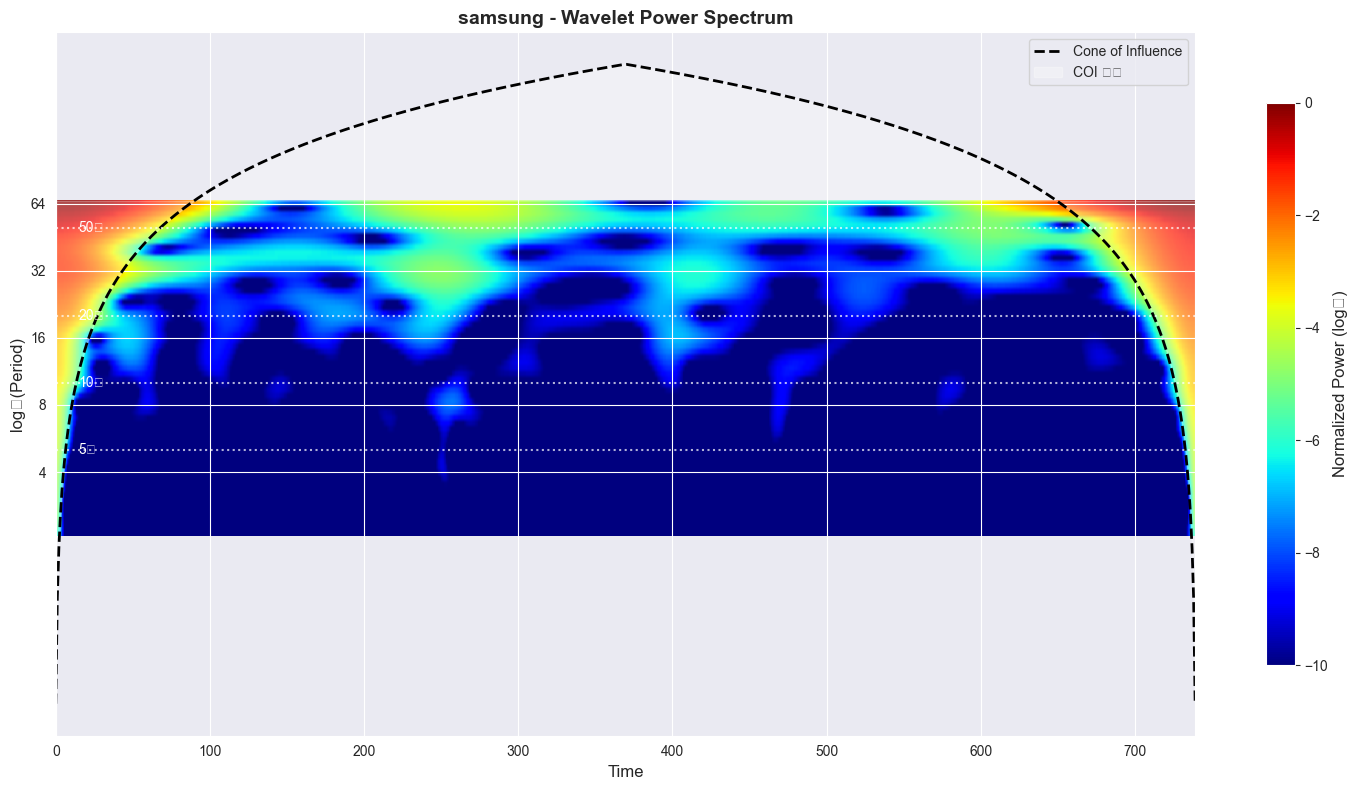

원본 길이 - time: 740, coi: 740, power 시간차원: 740


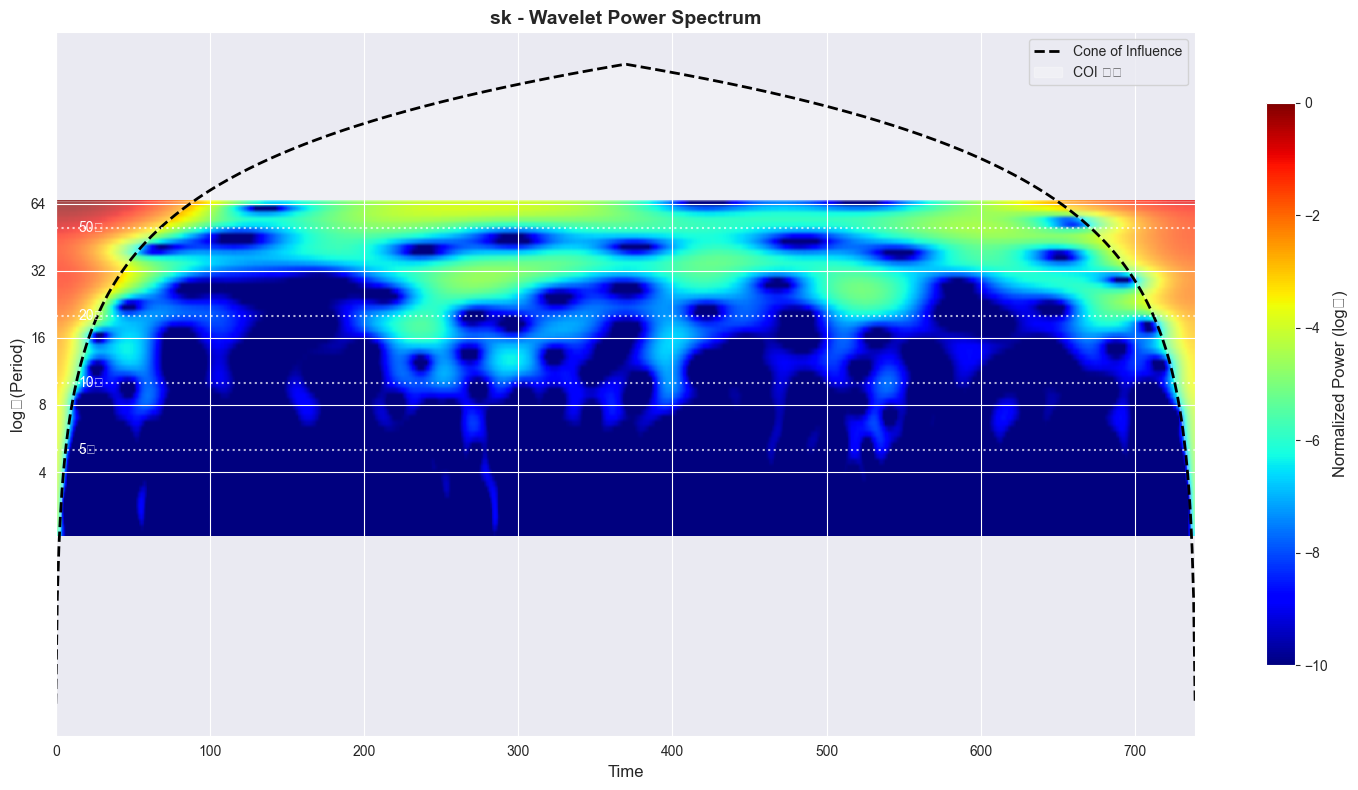

In [199]:
# 시각화 함수 호출
fig, ax = plot_individual_wavelet_spectrum(
    time=time_real,
    period=period_1,
    power=power_1,
    coi=coi_1,
    title="samsung - Wavelet Power Spectrum"
)

fig, ax = plot_individual_wavelet_spectrum(
    time=time_real,
    period=period_2,
    power=power_2,
    coi=coi_2,
    title="sk - Wavelet Power Spectrum"
)


# wavelet coherence calculation

In [206]:
def calculate_wavelet_coherence(signal1, signal2, dt=1.0, min_freq=0.005):
    """
    최소 주파수를 0.01Hz까지 낮춘 웨이브렛 코히어런스 계산
    """
    
    # 데이터 전처리
    signal1 = np.array(signal1).flatten().astype(float)
    signal2 = np.array(signal2).flatten().astype(float)
    
    min_len = min(len(signal1), len(signal2))
    signal1 = signal1[:min_len]
    signal2 = signal2[:min_len]
    
    # 웨이브렛 파라미터
    mother = wavelet.Morlet(6)
    s0 = dt*2  # 최소 스케일
    dj = 1/12  # 스케일 해상도
    
    # 최소 주파수에 대응하는 최대 주기 계산
    max_period = 1 / min_freq  # 0.01Hz → 100일 주기
    
    # J 계산: 최대 스케일까지 커버하도록 설정
    J = int(np.log2(max_period / s0) / dj)
    
    # 데이터 길이 제한 고려
    max_J_data = int(np.log2(min_len * dt / 4) / dj)  # 데이터 길이의 1/4까지
    J = min(J, max_J_data)
    
    # 최소 J 보장 및 최대 J 제한
    J = max(J, 20)  # 최소 20개 스케일
    J = min(J, 100)  # 최대 100개 스케일로 제한
    
    print(f"확장된 파라미터: s0={s0}, dj={dj}, J={J}")
    print(f"목표 최소 주파수: {min_freq}Hz (최대 주기: {max_period}일)")
    
    try:
        WCT, aWCT, coi, freq, sig = wavelet.wct(
            signal1, signal2, dt, dj=dj, s0=s0, J=J, 
            sig=False, wavelet=mother, normalize=True
        )
        
        # 실제 달성된 최소 주파수 확인
        actual_min_freq = freq.min()
        actual_max_period = 1 / actual_min_freq
        
        print(f"실제 달성된 최소 주파수: {actual_min_freq:.4f}Hz")
        print(f"실제 달성된 최대 주기: {actual_max_period:.1f}일")
        
        # sig가 0으로 채워져 있으므로 의미 있는 값으로 교체
        sig = np.ones((len(freq), len(signal1))) * 0.95
        
        return WCT, aWCT, coi, freq, sig
        
    except Exception as e:
        print(f"확장된 파라미터 실패: {e}")
        # 보수적 설정으로 폴백
        J = 60
        
        WCT, aWCT, coi, freq, sig = wavelet.wct(
            signal1, signal2, dt, dj=dj, s0=s0, J=J, 
            sig=False, wavelet=mother, normalize=True
        )
        sig = np.ones((len(freq), len(signal1))) * 0.95
        
        print(f"보수적 파라미터로 재계산: J={J}")
        return WCT, aWCT, coi, freq, sig


In [207]:
WCT, aWCT, coi, freq ,sig = calculate_wavelet_coherence(stock1_close, stock2_close,dt=1.0)

print(f"Wavelet Coherence Transform 형태: {WCT.shape}")
print(f"주파수 범위: {freq.min():.4f} - {freq.max():.4f}")
print(sig)

print(f"평균 coherence: {np.mean(np.abs(WCT)):.4f}")

확장된 파라미터: s0=2.0, dj=0.08333333333333333, J=79
목표 최소 주파수: 0.005Hz (최대 주기: 200.0일)
실제 달성된 최소 주파수: 0.0050Hz
실제 달성된 최대 주기: 198.1일
Wavelet Coherence Transform 형태: (80, 740)
주파수 범위: 0.0050 - 0.4840
[[0.95 0.95 0.95 ... 0.95 0.95 0.95]
 [0.95 0.95 0.95 ... 0.95 0.95 0.95]
 [0.95 0.95 0.95 ... 0.95 0.95 0.95]
 ...
 [0.95 0.95 0.95 ... 0.95 0.95 0.95]
 [0.95 0.95 0.95 ... 0.95 0.95 0.95]
 [0.95 0.95 0.95 ... 0.95 0.95 0.95]]
평균 coherence: 0.6363


# plot coherence

In [208]:
# 올바른 시간 배열 생성
def create_consistent_time_array(WCT_shape, dt=1.0):
    """
    웨이브렛 변환 결과에 맞는 시간 배열 생성
    """
    time_length = WCT_shape[1]  # WCT의 시간 차원
    return np.arange(time_length) * dt

# 사용 예시
correct_time = create_consistent_time_array(WCT.shape)


In [209]:
# COI 배열 길이 확인 및 조정
def validate_coi_array(coi, target_length):
    """
    COI 배열을 목표 길이에 맞춰 조정
    """
    if len(coi) != target_length:
        print(f"COI 길이 조정: {len(coi)} -> {target_length}")
        
        if len(coi) > target_length:
            # 트리밍
            return coi[:target_length]
        else:
            # 선형 보간으로 확장
            from scipy.interpolate import interp1d
            old_indices = np.linspace(0, target_length-1, len(coi))
            new_indices = np.arange(target_length)
            f = interp1d(old_indices, coi, kind='linear', fill_value='extrapolate')
            return f(new_indices)
    
    return coi

# 사용 예시
coi_adjusted = validate_coi_array(coi, WCT.shape[1])


In [210]:
def plot_wavelet_coherence(time, freq, WCT, coi, sig, 
                                    title="Wavelet Coherence Spectrum"):
    """
    COI 불일치 문제를 해결한 웨이브렛 코히어런스 시각화
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 배열 길이 일치 확인
    wct_time_len = WCT.shape[1]
    
    # 시간 배열 조정
    if len(time) != wct_time_len:
        time_adjusted = np.arange(wct_time_len)
        print(f"시간 배열 조정: {len(time)} -> {wct_time_len}")
    else:
        time_adjusted = time
    
    # COI 배열 조정
    coi_adjusted = validate_coi_array(coi, wct_time_len)
    
    # 주파수 범위 확인
    period = 1 / freq
    
    # extent 설정 (주파수 기준)
    extent = [time_adjusted.min(), time_adjusted.max(), 
              freq.min(), freq.max()]
    
    # 웨이브렛 코히어런스 스펙트럼 플롯
    im = ax.imshow(np.abs(WCT), extent=extent, cmap='jet', 
                   aspect='auto', origin='lower', vmin=0, vmax=1)
    
    # COI를 주파수로 변환하여 표시
    try:
        coi_freq = 1 / coi_adjusted  # 주기를 주파수로 변환
        
        # COI 범위 검증
        valid_mask = (coi_freq >= freq.min()) & (coi_freq <= freq.max())
        
        if np.any(valid_mask):
            ax.plot(time_adjusted[valid_mask], coi_freq[valid_mask], 
                   'k--', linewidth=2, label='Cone of Influence')
            
            # COI 영역 채우기
            ax.fill_between(time_adjusted[valid_mask], 
                           coi_freq[valid_mask], freq.max(),
                           alpha=0.3, color='white', label='COI 영역')
        else:
            print("경고: COI가 현재 주파수 범위를 벗어납니다.")
            
    except Exception as e:
        print(f"COI 플롯 실패: {e}")
    
    # 컬러바 및 레이블
    plt.colorbar(im, ax=ax, shrink=0.8, label='Wavelet Coherence')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Frequency (Hz)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축을 로그 스케일로 설정
    ax.set_yscale('log')
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax


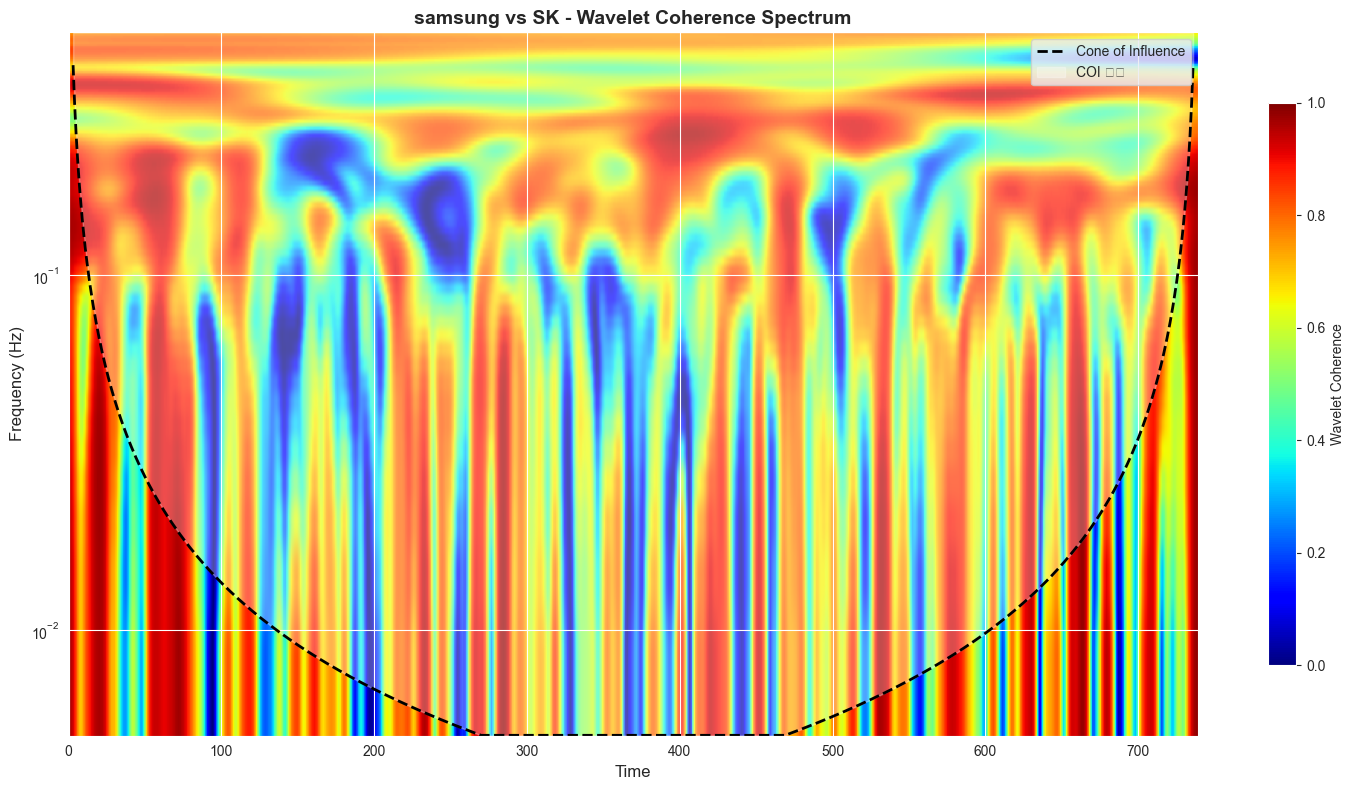

In [211]:

correct_time = np.arange(WCT.shape[1])

# 수정된 함수로 시각화
fig3, ax3 = plot_wavelet_coherence(
    time=correct_time,
    freq=freq,
    WCT=WCT,
    coi=coi,
    sig=sig,
    title="samsung vs SK - Wavelet Coherence Spectrum"
)